### Imports
We import all the necessary libraries for our analysis

In [187]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime 

### Data

In [188]:
# Data selection
tickers = ["RHM.DE", "AIR.PA", "LDO.MI", "BA.L"]
start_date = "2020-10-21"   
end_date = "2025-10-21"
price_column = "Adj Close"
output_folder = "outputs"
os.makedirs(output_folder, exist_ok=True)

# Download
prices = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']


# Clean potential missing data
prices = prices.sort_index().dropna(how='all').ffill()

print("Dates:", prices.index.min().date(), "—", prices.index.max().date())
display(prices.round(2).head())

prices.to_csv(os.path.join(output_folder, "prices.csv"))
print("Saved to outputs/prices.csv")


Dates: 2020-10-21 — 2025-10-20


Ticker,AIR.PA,BA.L,LDO.MI,RHM.DE
Date,,,,
2020-10-21,59.86,464.16,4.46,67.86
2020-10-22,60.22,441.69,4.43,66.65
2020-10-23,63.57,457.37,4.53,67.30
2020-10-26,61.53,447.18,4.39,64.98
2020-10-27,59.80,431.30,4.21,60.91


Saved to outputs/prices.csv


### Returns Calculation

In [189]:
# Compute daily returns

returns = prices.pct_change().dropna()  # in decimal form


returns_pct = returns * 100  # in percentage form

# Round and display
display(returns_pct.round(2))


# Save to file (optional)
returns.to_csv(os.path.join(output_folder, "returns.csv"))
print("Saved daily returns to outputs/returns.csv")


Ticker,AIR.PA,BA.L,LDO.MI,RHM.DE
Date,,,,
2020-10-22,0.61,-4.84,-0.58,-1.78
2020-10-23,5.55,3.55,2.27,0.97
2020-10-26,-3.20,-2.23,-3.04,-3.45
2020-10-27,-2.81,-3.55,-4.20,-6.26
2020-10-28,-3.48,-4.24,-4.00,-3.54
...,...,...,...,...
2025-10-14,0.47,0.15,-0.80,-2.18
2025-10-15,-0.15,-2.74,-4.20,-5.09
2025-10-16,1.21,0.37,1.24,1.69


Saved daily returns to outputs/returns.csv


### Porfolio simulation
We generate random combinations of portfolio weights (that sum to 1) and for each combination we compute the expected portfolio return, the portfolio volatility (standard deviation) and the Sharpe Ratio. To do that we'll use Numpy.

In [190]:
n_assets = returns.shape[1]   # number of stocks (should be 4)
n_portfolios = 5000           # number of random portfolios to simulate

# Generate random weights that sum to 1
weights = np.random.random((n_portfolios, n_assets))
weights /= weights.sum(axis=1)[:, np.newaxis]  # normalize so each row sums to 1


# Compute mean returns and covariance matrix
mean_daily_returns = returns.mean()
cov_matrix = returns.cov()

# Annualise mean returns and covariance matrix assuming 252 trading days per year
mean_annual_returns = mean_daily_returns * 252
cov_annual = cov_matrix * 252

# Compute portfolio returns, volatilities adn Sharpe Ratios
port_returns = []
port_vols = []
port_sharpes = []

for w in weights:
    ret = np.dot(w, mean_annual_returns)
    vol = np.sqrt(np.dot(w.T, np.dot(cov_annual, w)))
    sharpe = ret / vol  # assuming a risk-free rate equal to zero
    port_returns.append(ret)
    port_vols.append(vol)
    port_sharpes.append(sharpe)
    
portfolios = pd.DataFrame({
    'Return': port_returns,
    'Volatility': port_vols,
    'Sharpe': port_sharpes
})


portfolios_display = portfolios.copy()
portfolios_display['Return'] *= 100
portfolios_display['Volatility'] *= 100
portfolios_display.rename(columns={
    'Return': 'Return (%)',
    'Volatility': 'Volatility (%)'
}, inplace=True)

display(portfolios_display.round({'Return (%)': 2, 'Volatility (%)': 2, 'Sharpe': 3}).head())




,Return (%),Volatility (%),Sharpe
0,45.52,25.74,1.768
1,49.01,31.20,1.571
2,60.28,32.30,1.866
3,44.42,26.86,1.654
4,39.74,24.17,1.644


### Visualisation

Max Sharpe index: 880
Return        0.569111
Volatility    0.303601
Sharpe        1.874535
Name: 880, dtype: float64


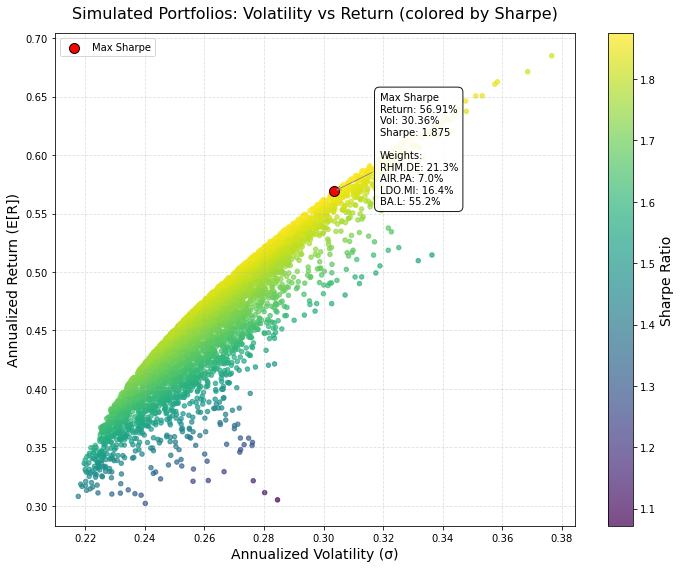

In [198]:

# Firstly, we add all the portfolio weights to our data frame
for i, t in enumerate(tickers):
    portfolios[f"W_{t}"] = weights[:, i]

# --- Identify max-Sharpe portfolio ---
max_sharpe_idx = portfolios["Sharpe"].idxmax()
max_sharpe = portfolios.loc[max_sharpe_idx]
print("Max Sharpe index:", max_sharpe_idx)
print(max_sharpe[["Return", "Volatility", "Sharpe"]])


# --- Scatter: Volatility vs Return, color by Sharpe ---
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(portfolios["Volatility"], portfolios["Return"],
                c=portfolios["Sharpe"], alpha=0.7, cmap='viridis', s=20)

# highlight max-Sharpe
ax.scatter(max_sharpe["Volatility"], max_sharpe["Return"],
           c='red', s=100, marker='o', edgecolors='k', label="Max Sharpe")

# add labels and grid
ax.set_xlabel("Annualized Volatility (σ)", fontsize=14)
ax.set_ylabel("Annualized Return (E[R])", fontsize=14)
ax.set_title("Simulated Portfolios: Volatility vs Return (colored by Sharpe)", fontsize=16, pad=15)
ax.grid(True, linestyle='--', alpha=0.4)
fig.tight_layout()

# colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Sharpe Ratio", fontsize=14)

# annotate the max Sharpe point with the weights and stats
# format values to percent for clarity
ret_pct = max_sharpe["Return"] * 100
vol_pct = max_sharpe["Volatility"] * 100
sh = max_sharpe["Sharpe"]
weights_cols = [c for c in portfolios.columns if c.startswith("W_")]
weights_text = "\n".join([f"{c.replace('W_','')}: {max_sharpe[c]*100:.1f}%" for c in weights_cols])
annot_text = f"Max Sharpe\nReturn: {ret_pct:.2f}%\nVol: {vol_pct:.2f}%\nSharpe: {sh:.3f}\n\nWeights:\n{weights_text}"

# place annotation offset from the point
ax.annotate(annot_text, xy=(max_sharpe["Volatility"], max_sharpe["Return"]),
            xytext=(max_sharpe["Volatility"]*1.05, max_sharpe["Return"]*0.98),
            bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.9),
            fontsize=10, arrowprops=dict(arrowstyle="->", color='gray', lw=0.8))

ax.legend()
fig_path = os.path.join(output_folder, "portfolios_scatter.png")
fig.savefig(fig_path, dpi=300, bbox_inches="tight") # saves scatter plot to outputs/portfolios_scatter.png

plt.show()



### Highest Sharpe-Ratio Portfolio, Summary

In [203]:

# We highlight the return, volatility, sharpe ratio and weights of the portfolio with the highest Sharpe Ratio
summary_cols = ["Return", "Volatility", "Sharpe"] + weights_cols
summary = max_sharpe[summary_cols].copy()
summary["Return"] *= 100
summary["Volatility"] *= 100
summary[weights_cols] *= 100

display(summary.to_frame().T.round(2))

summary.to_csv(os.path.join(output_folder, "max_sharpe_summary.csv"))
print("Saved summary to outputs/max_sharpe_summary.csv")



,Return,Volatility,Sharpe,W_RHM.DE,W_AIR.PA,W_LDO.MI,W_BA.L
880,56.91,30.36,1.87,21.33,7.0,16.42,55.25


Saved summary to outputs/max_sharpe_summary.csv


### Conclusion
This analysis simulates risk–return trade-offs for a portfolio of four European defence stocks — Rheinmetall (RHM.DE), Airbus (AIR.PA), Leonardo (LDO.MI), and BAE Systems (BAE.L). Using historical price data from Yahoo Finance, daily returns were computed and thousands of random portfolio weight combinations were simulated. Each portfolio’s expected annual return, volatility, and Sharpe ratio were calculated to evaluate performance. A scatter plot of simulated portfolios highlights the return and volatility of all portfolios, with the maximum-Sharpe portfolio clearly identified. 

The analysis identified an optimal allocation based on the highest Sharpe ratio of 1.87. The resulting mix allocates approximately 55% to BAE Systems, 21% to Rheinmetall, 16% to Leonardo, and 7% to Airbus. This combination achieved an expected annualized return of around 56.9% with a volatility of 30.4%. 

The analysis suggests that, over the historical period studied, a portfolio heavily weighted toward BAE Systems offered the best balance between risk and return within the defence sector. Rheinmetall contributed strong growth potential, while Airbus and Leonardo provided diversification benefits. However, the exceptionally high expected return largely reflects recent sector performance and may not be sustainable under future market conditions. 

Overall, the results highlight how portfolio optimization can identify efficient risk–return trade-offs even within a single industry, and demonstrate the value of diversification among correlated assets.

